In [1]:
import math

x = [ _x * 0.1 for _x in range(100000)]
sin_x = [ math.sin(_x) for _x in x ]
dataset = list(zip(x, sin_x))

split = math.floor(len(dataset) * 0.8)
training_data = dataset[0:split]
test_data = dataset[split:]

print("Training data: %d items." % len(training_data))
print("Test data: %d items." % len(test_data))

Training data: 80000 items.
Test data: 20000 items.


In [2]:
import matplotlib.pyplot as plt

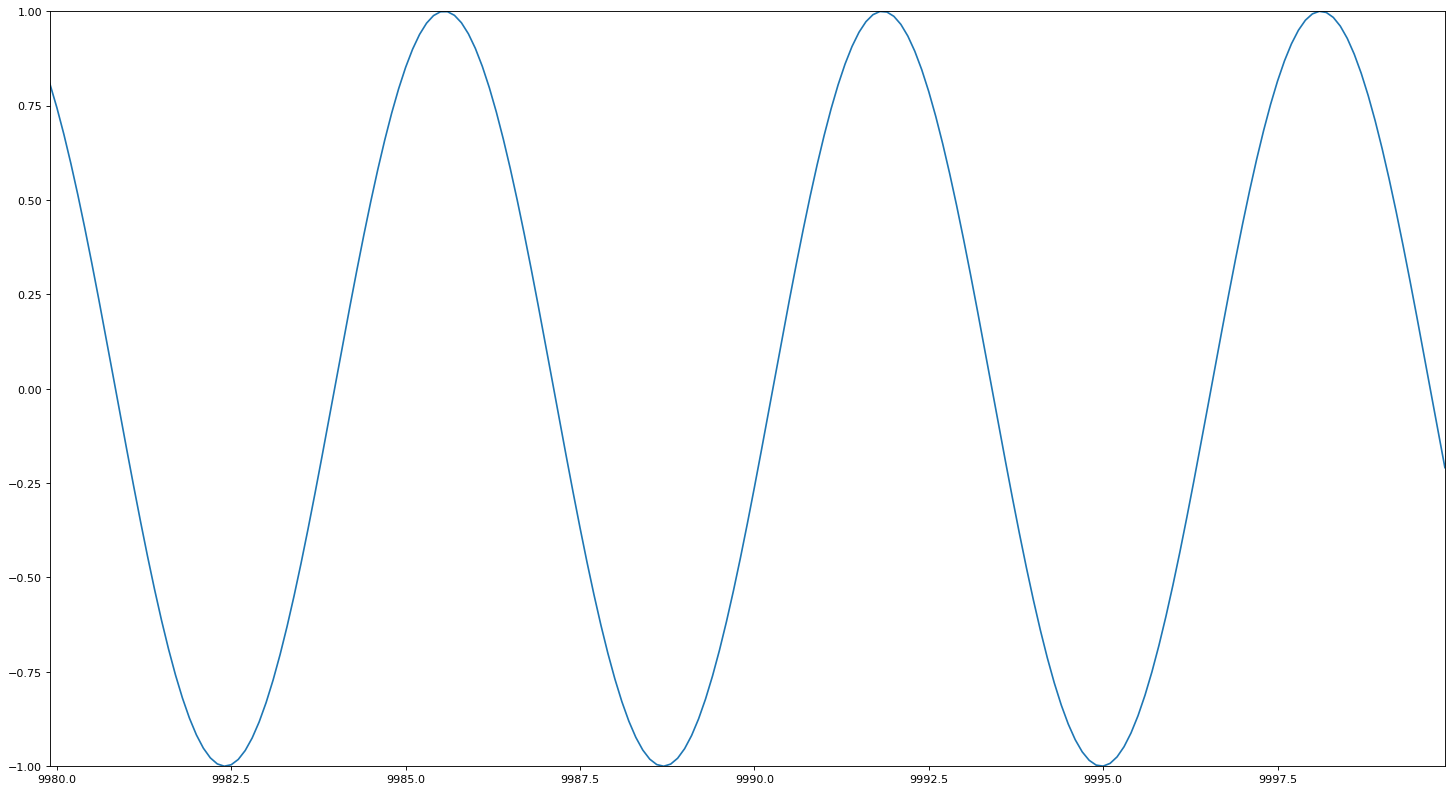

In [3]:
plt.figure(num=1, figsize=(1800 / 80, 1000 / 80), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, sin_x)
end = max(x)
plt.axis([end - 20, end, -1, 1])
plt.show()

In [4]:
def test_ann(got, expected, tolerance):
    if got < expected + tolerance and got > expected - tolerance:
        return True
    else:
        return False

In [5]:
import tensorflow as tf

In [6]:
def train_and_evaluate(graph, tolerance=0.1):
    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())
        for idx, data in enumerate(training_data):
            _, current_loss = session.run([trainer, loss],
                                    feed_dict={
                                        x: data[0],
                                        y_expected: data[1]
                                    })
        print("Final loss: %.10f" % current_loss)

        successes = 0
        for data in training_data:
            result = session.run(y, feed_dict={x: data[0]})
            if test_ann(result[0], data[1], tolerance):
                successes += 1
        print("%.2f%% self successes." % (100.0 * successes / len(training_data)))
        
        successes = 0
        tests = []
        results = []
        for data in test_data:
            result = session.run(y, feed_dict={x: data[0]})
            if test_ann(result[0], data[1], tolerance):
                successes += 1
            tests.append(data[0])
            results.append(float(result[0]))
        print("%.2f%% test successes." % (100.0 * successes / len(test_data)))
        return (tests, results)

In [7]:
no_hidden = tf.Graph()
with no_hidden.as_default():
    Weights = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
    biases = tf.Variable(tf.zeros([1]))
    
    x = tf.placeholder(tf.float32)
    y_expected = tf.placeholder(tf.float32)
    y = tf.sigmoid(Weights * x + biases)
    
    loss = tf.reduce_mean(tf.square(y - y_expected))
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    trainer = optimizer.minimize(loss)

for tolerance in [0.1]:
    print("Tolerance: %s" % tolerance)
    results_no_hidden = train_and_evaluate(no_hidden, tolerance)
    print()

Tolerance: 0.1
Final loss: 0.0001875694
14.36% self successes.
14.36% test successes.



In [8]:
simple_hidden = tf.Graph()
with simple_hidden.as_default():
    front_layer = tf.Variable(tf.random_uniform([2, 1], -1.0, 1.0))
    front_biases = tf.Variable(tf.zeros([1]))
    hidden_layer = tf.Variable(tf.random_uniform([1, 2], -1.0, 1.0))
    hidden_biases = tf.Variable(tf.zeros([1]))
    
    x = tf.placeholder(tf.float32)
    y_expected = tf.placeholder(tf.float32)
    inner_y = tf.sigmoid(front_layer * x + front_biases)
    y = tf.sigmoid(tf.tensordot(hidden_layer, inner_y, axes=1) + hidden_biases)
    
    loss = tf.reduce_mean(tf.square(y - y_expected))
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    trainer = optimizer.minimize(loss)

for tolerance in [0.1]:
    print("Tolerance: %s" % tolerance)
    results_simple_hidden = train_and_evaluate(simple_hidden, tolerance)
    print()

Tolerance: 0.1
Final loss: 0.9477992058
6.38% self successes.
6.37% test successes.



In [9]:
def plot_against_sin(points):
    x, y = points
    plt.figure(num=1, figsize=(1800 / 80, 1000 / 80), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(x, [ math.sin(a) for a in x ])
    plt.plot(x, y)
    end = max(x)
    plt.axis([end - 20, end, -1, 1])
    plt.show()

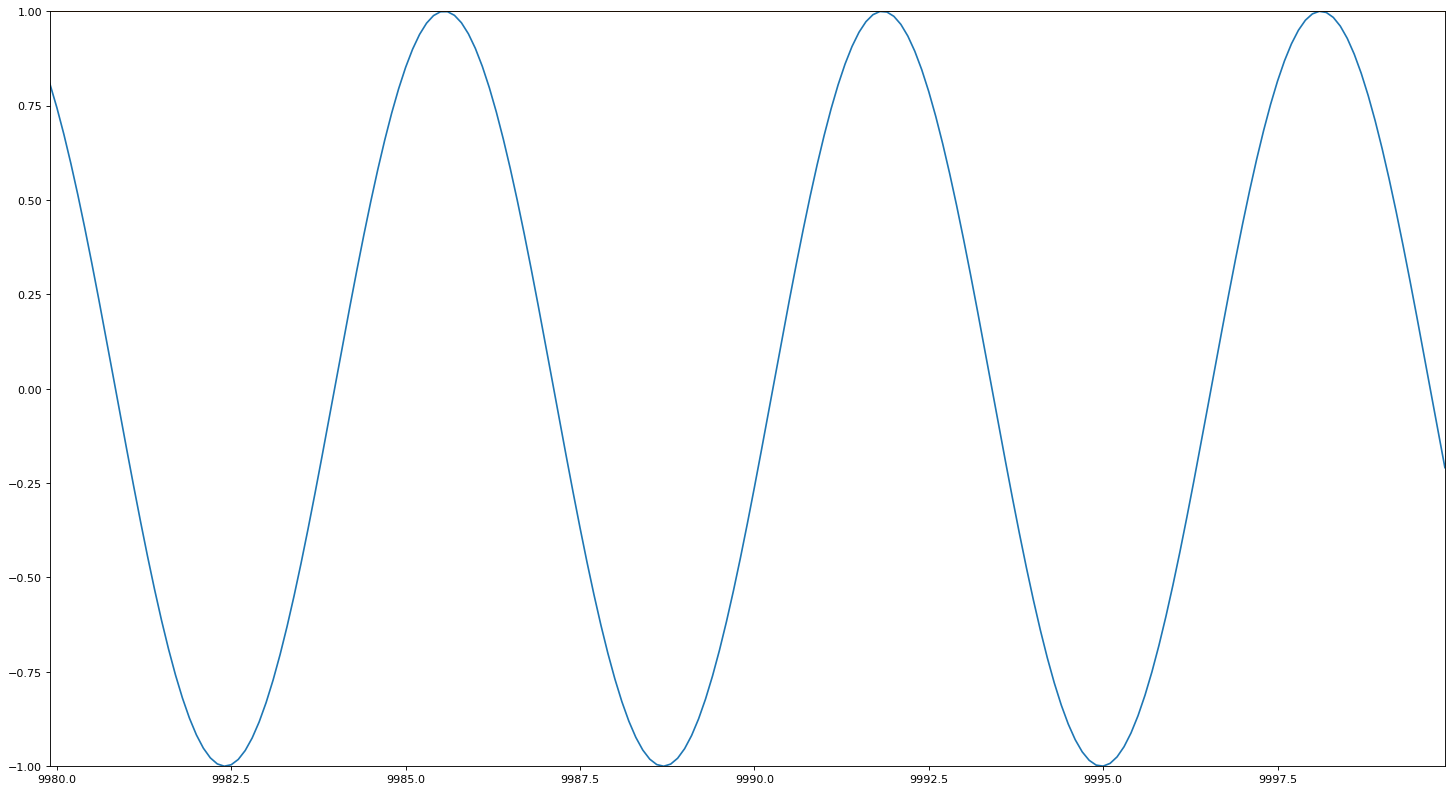

In [10]:
plot_against_sin(results_no_hidden)

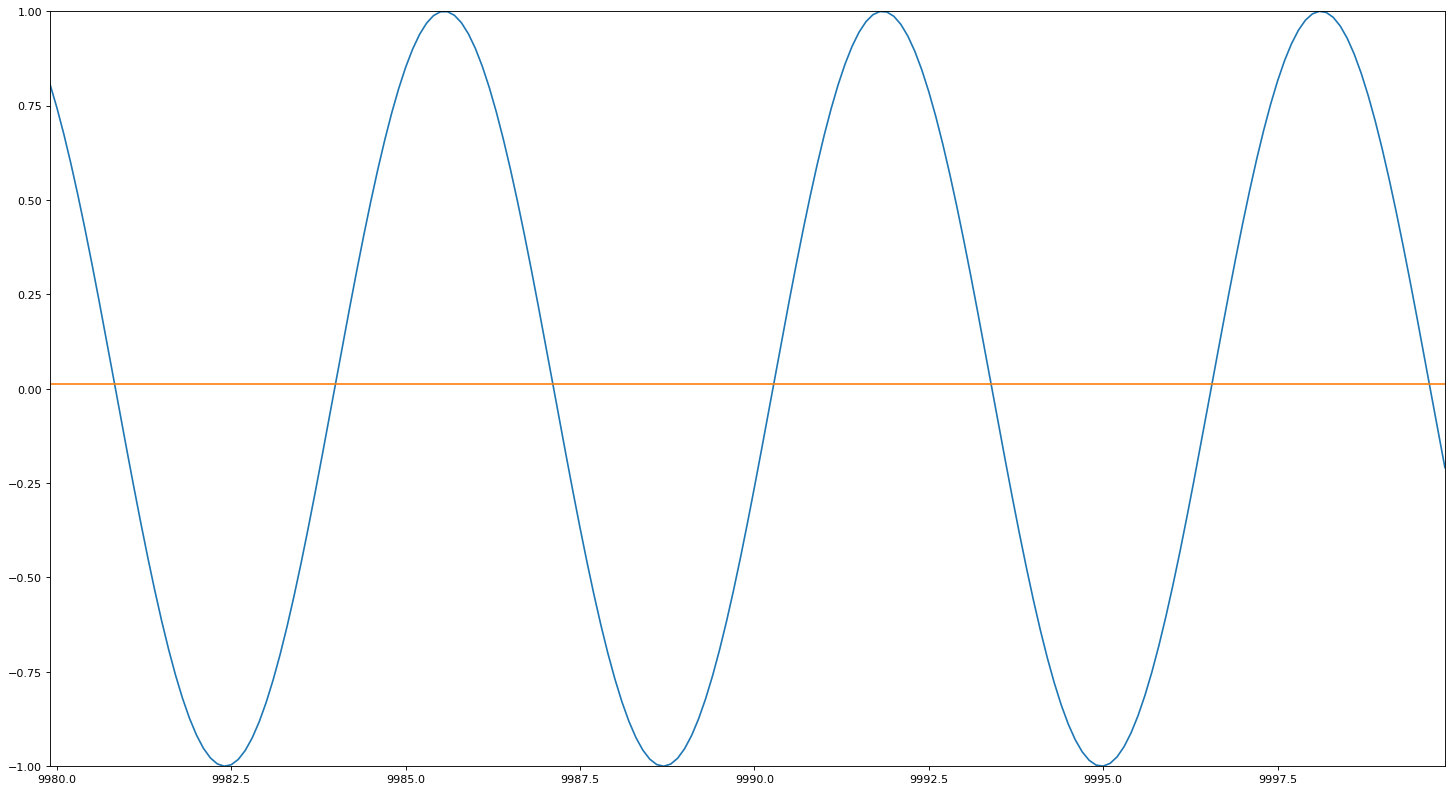

In [11]:
plot_against_sin(results_simple_hidden)

In [12]:
chain_split = math.floor(len(sin_x) * 0.8)
chain_training_data = sin_x[0:chain_split]
chain_test_data = sin_x[chain_split:]

def chain_train_and_evaluate(graph, chain_length=10, tolerance=0.1):
    with tf.Session(graph=graph) as session:
        session.run(tf.global_variables_initializer())
        
        n = chain_length + 1
        chunks = [ chain_training_data[i:i + n] for i in range(0, len(chain_training_data), n) ]
        
        for data in chunks:
            if len(data) < n:
                print("No more data")
                break
            _, current_loss = session.run([trainer, loss],
                                    feed_dict={
                                        x: data[0:-1],
                                        y_expected: data[-1]
                                    })
        print("Final loss: %.10f" % current_loss)

        successes = 0
        for data in chunks:
            if len(data) < n:
                print("No more data")
                break
            result = session.run(y, feed_dict={x: data[0:-1]})
            if test_ann(float(result[0]), data[-1], tolerance):
                successes += 1
        print("%.2f%% self successes." % (100.0 * successes / len(training_data)))
        
        successes = 0
        xs = []
        results = []
        test_chunks = [ chain_test_data[i:i + n] for i in range(0, len(chain_test_data), n) ]
        for x_, data in enumerate(test_chunks):
            if len(data) < n:
                print("No more data")
                break
            result = session.run(y, feed_dict={x: data[0:-1]})
            if test_ann(float(result[0]), data[-1], tolerance):
                successes += 1
            xs.append(x_)
            results.append(float(result[0]))
        print("%.2f%% test successes." % (100.0 * successes / len(test_data)))
        return (xs, results)

In [13]:
chain_len = 10
simple_chain = tf.Graph()
with simple_chain.as_default():
    Weights = tf.Variable(tf.random_uniform([1, chain_len], -1.0, 1.0))
    biases = tf.Variable(tf.zeros([1]))
    
    x = tf.placeholder(tf.float32, shape=(chain_len))
    y_expected = tf.placeholder(tf.float32)
    y = tf.sigmoid(tf.tensordot(Weights, x, axes=1) + biases)
    
    loss = tf.reduce_mean(tf.square(y - y_expected))
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    trainer = optimizer.minimize(loss)

for tolerance in [0.1]:
    print("Tolerance: %s" % tolerance)
    results_simple_chain = chain_train_and_evaluate(simple_chain, chain_len, tolerance)
    print()

Tolerance: 0.1
No more data
Final loss: 0.0002349546
No more data
4.75% self successes.
No more data
4.75% test successes.



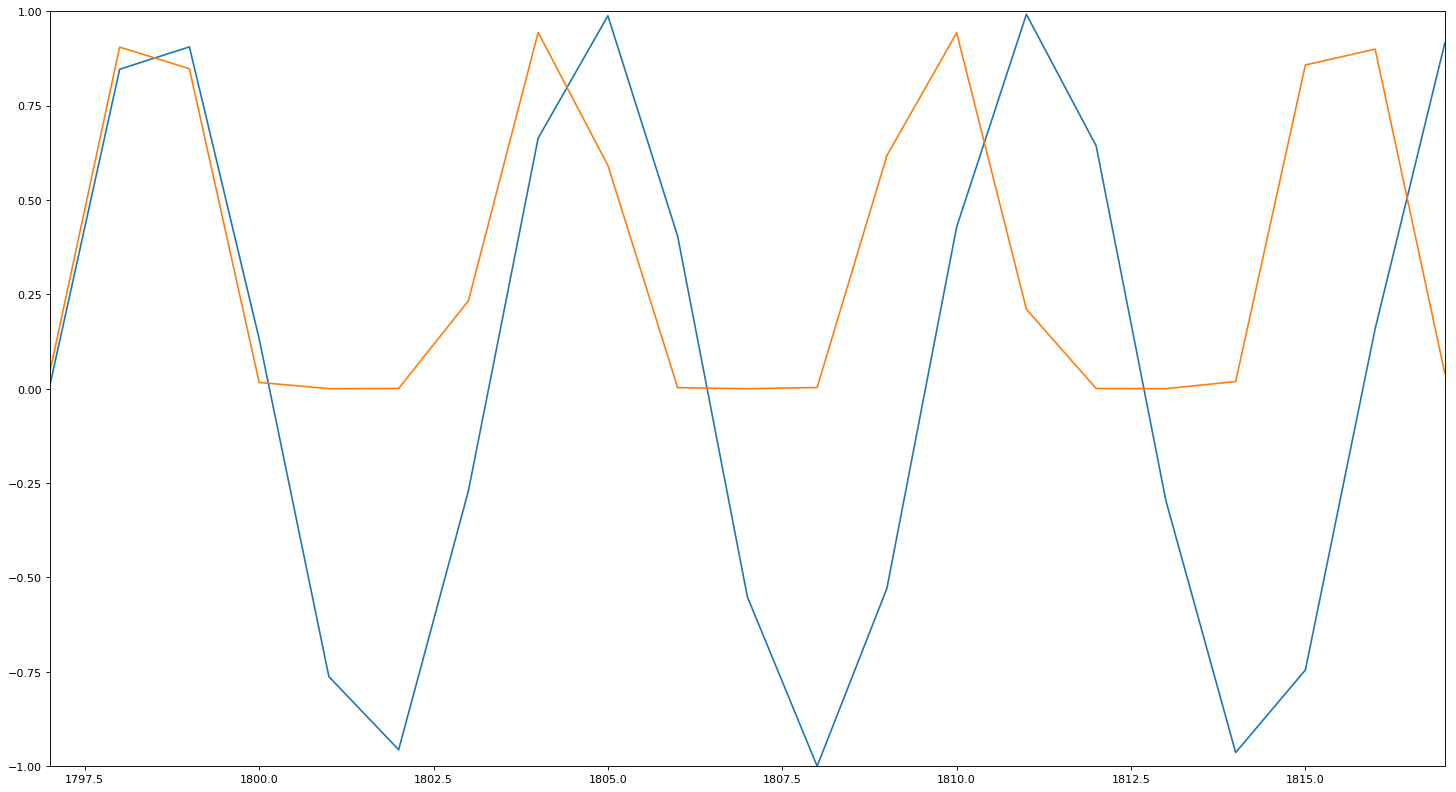

In [14]:
plot_against_sin(results_simple_chain)